# Town of Cary Food Waste Data

The purpose of this analysis is to conduct initial exploration of the Town of Cary's Food Waste Recylcing data with the intent of learning more about the information that's been collected up to this point. 

In [32]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

In [3]:
DATA_PATH = "C:\\Users\\kmkei\\Documents\\Projects\\food_waste\\data"

## Functions

In [5]:
def clean_column_names(df):
  """
  Converts column names to lowercase and replaces spaces with underscores.

  Args:
    df: Pandas DataFrame.

  Returns:
    Pandas DataFrame with cleaned column names.
  """
  df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("-", "_")
  return df

## Read in Data

This data is publicy available and comes from this source: https://data.townofcary.org/pages/food-waste-pilot-data-story/

There are two files available:

1. `food-waste-pilot.csv`: contains collection amounts (in pounds) and estimated compost created (in pounds) for each drop off location for each collection date.
2. `food-waste-recycling-participation.csv`: this data contains the estimated number of drop-offs at the pilot drop off site; NB this data is manually entered, so may be less accurate/reliable.

In [6]:
# read in collection data
coll_wk = pd.read_csv(os.path.join(DATA_PATH, "food-waste-pilot.csv"))

# clean up column names and convert date
coll_wk = clean_column_names(coll_wk)
coll_wk['collection_date'] = pd.to_datetime(coll_wk['collection_date'])

In [7]:
# read in estimated number of collections
part = pd.read_csv(os.path.join(DATA_PATH, "food-waste-recycling-participation.csv"))

# clean up column names and convert date
part = clean_column_names(part)
part['date'] = pd.to_datetime(part['date'])

## Exploration

### Check values, check for duplicates, etc.

In [8]:
# check data types
coll_wk.dtypes

stop_name                                   object
collection_date                     datetime64[ns]
food_waste_collected                       float64
estimated_earned_compost_created           float64
dtype: object

In [65]:
# check data types
part.dtypes

date                                         datetime64[ns]
estimated_drop_offs_containing_food_waste             int64
dtype: object

In [20]:
# number of rows
coll_wk.shape[0]

594

In [25]:
# number of drop off locations - 2
coll_wk['stop_name'].nunique()

2

In [26]:
# number of dates with data - 450
coll_wk['collection_date'].nunique()

450

In [28]:
# number of dates per collection location
coll_wk.groupby('stop_name').agg({'collection_date': 'nunique'})

,collection_date
stop_name,
Citizen's Convenience Center,449
Mills Park,144


In [29]:
# are rows unique to collection location-date combinations? there's one date-location that had multiple rowsb
temp = coll_wk.groupby(['stop_name', 'collection_date']).agg({'food_waste_collected': 'count'})
temp[temp['food_waste_collected'] > 1]

,,food_waste_collected
stop_name,collection_date,
Citizen's Convenience Center,2024-11-01,2


In [35]:
coll_wk[(coll_wk['stop_name'] == "Citizen's Convenience Center") & (coll_wk['collection_date'] == pd.to_datetime("2024-11-01"))]

,stop_name,collection_date,food_waste_collected,estimated_earned_compost_created
110,Citizen's Convenience Center,2024-11-01,481.8,48.0
470,Citizen's Convenience Center,2024-11-01,867.0,87.0


It's not clear to me at this point why there are multiple records for this location/date. I have a few hypotheses:

* It could be that these records should be summed together; for whatever reason two valid logs were created for this location-date, so they should be aggregated
* Only the second record should be kept (the one with larger amount of collection); it could be that the first record just reflects part of the day's collection, so summing them would be double counting some collections
* One of the records could be mislabeled: may be the wrong location or date was entered for this collection

Of course, without asking data subject-matter experts these questions, it's hard to know which is correct. I'm hoping after visualizing the data and investigating more, one of these hypotheses will be more likely than the others, and I can adjust the data at that point.

In [47]:
# distribution statistics of numeric columns
coll_wk.describe(include="all")

,stop_name,collection_date,food_waste_collected,estimated_earned_compost_created
count,594,594,594.000000,594.000000
unique,2,NaN,NaN,NaN
top,Citizen's Convenience Center,NaN,NaN,NaN
freq,450,NaN,NaN,NaN
mean,NaN,2023-10-17 19:01:49.090909184,624.005219,62.353535
min,NaN,2022-02-02 00:00:00,0.000000,0.000000
25%,NaN,2023-01-20 18:00:00,430.650000,43.000000
50%,NaN,2024-01-11 00:00:00,584.500000,58.000000
75%,NaN,2024-07-12 00:00:00,747.850000,75.000000
max,NaN,2024-12-31 00:00:00,2057.000000,206.000000


In [48]:
# any missing values? nope!
coll_wk.isna().mean()*100

stop_name                           0.0
collection_date                     0.0
food_waste_collected                0.0
estimated_earned_compost_created    0.0
dtype: float64

In [63]:
# number of rows
part.shape[0]

1070

In [19]:
# number of dates in "estimated number of drop offs" data
part['date'].nunique()

1068

In [60]:
# are rows and dates one to one? yes there are a couple of dates with multiple rows
temp = part.groupby("date").agg({'estimated_drop_offs_containing_food_waste':'count'})
temp[temp['estimated_drop_offs_containing_food_waste'] > 1]

,estimated_drop_offs_containing_food_waste
date,
2022-02-23,2
2023-01-08,2


In [61]:
part[(part['date'].isin([pd.to_datetime("2022-02-23"), pd.to_datetime("2023-01-08")]))].sort_values("date")

,date,estimated_drop_offs_containing_food_waste
86,2022-02-23,55
634,2022-02-23,26
76,2023-01-08,8
757,2023-01-08,37


Again, it's not immediately clear why there are multiple rows for these dates. I think similar hypotheses from the other dataset apply here. I'll visualize and analyze further, and hope that one option becomes more likely.

In [62]:
# any missing values? nope!
part.isna().mean()*100

date                                         0.0
estimated_drop_offs_containing_food_waste    0.0
dtype: float64

### Visualize

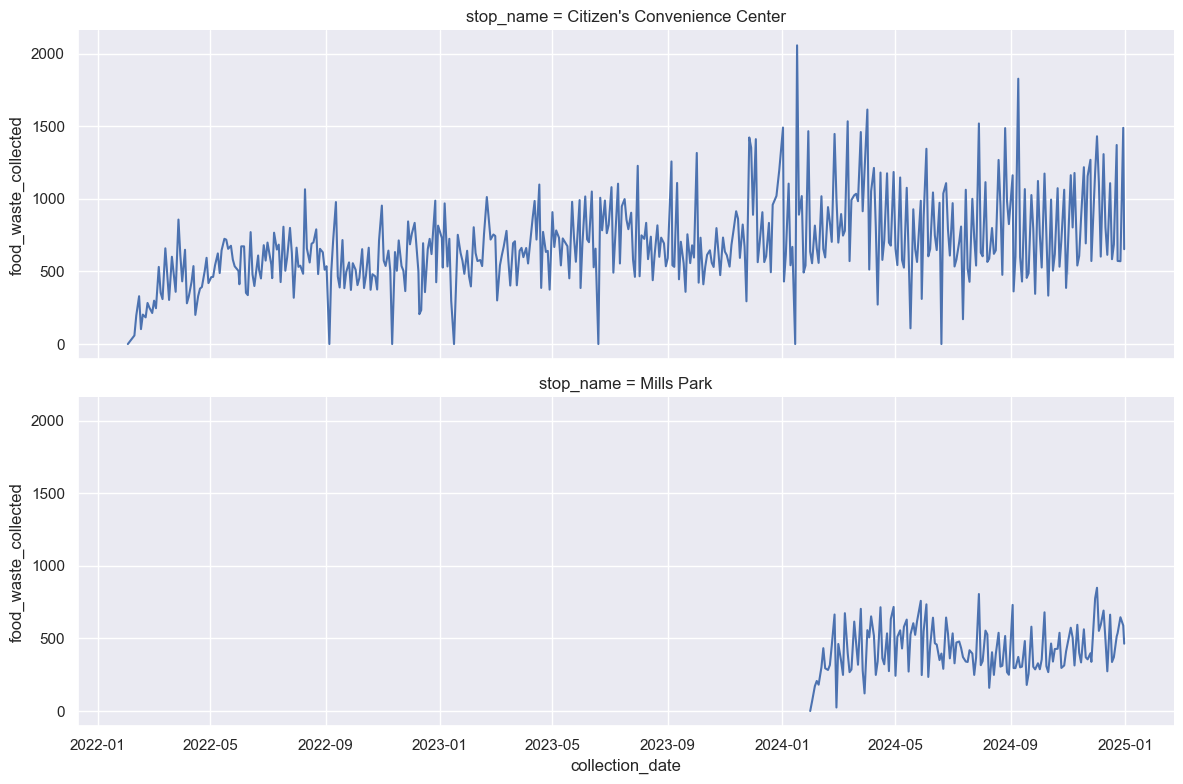

In [33]:
# visualize data over time
g = sns.FacetGrid(coll_wk, col="stop_name", col_wrap=1, height=4, aspect=3)
g.map_dataframe(sns.lineplot, x="collection_date", y="food_waste_collected")

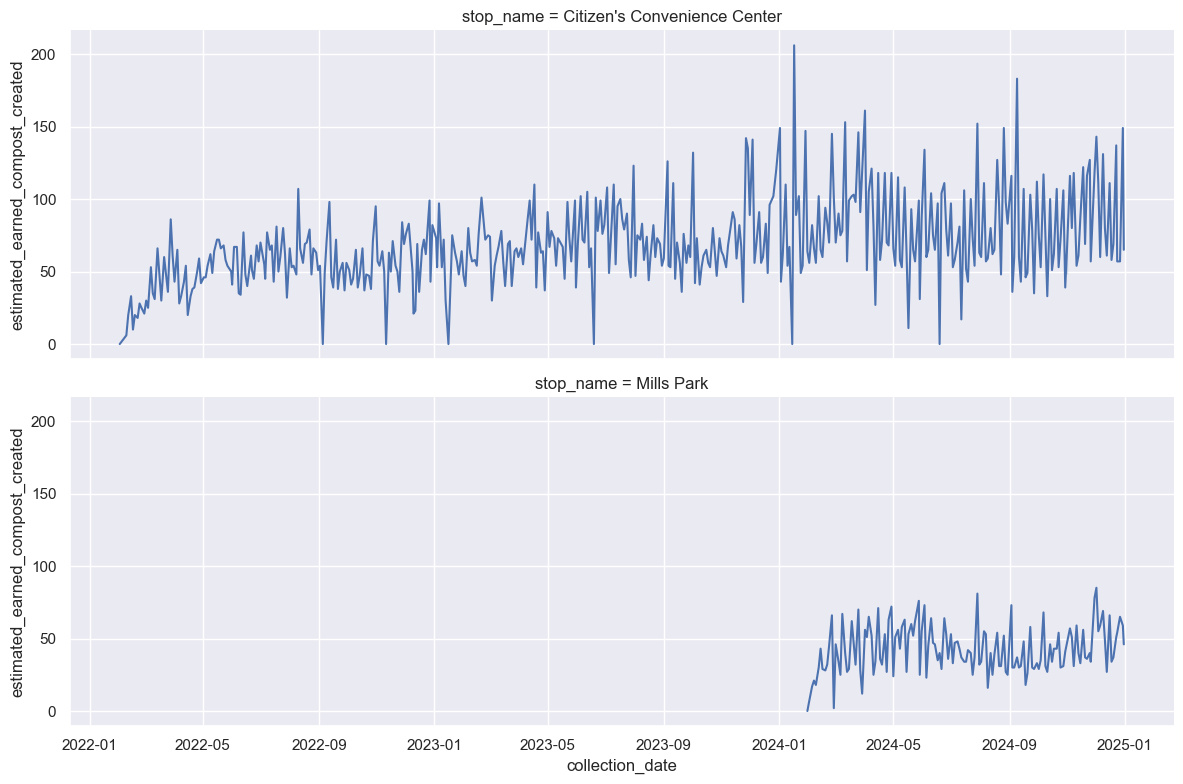

In [34]:
# visualize data over time
g = sns.FacetGrid(coll_wk, col="stop_name", col_wrap=1, height=4, aspect=3)
g.map_dataframe(sns.lineplot, x="collection_date", y="estimated_earned_compost_created")

Seems like for both locations, the collection amounts have been pretty steady over time (with a decent amount of variation date over date), with maybe a very gradual upward trend for "citizen's convenience center".

In [68]:
# what's the typical day gap between collections?
coll_wk = coll_wk.sort_values(by=['stop_name', 'collection_date'])
coll_wk['days_since_last_coll'] = coll_wk.groupby('stop_name')['collection_date'].diff().dt.days

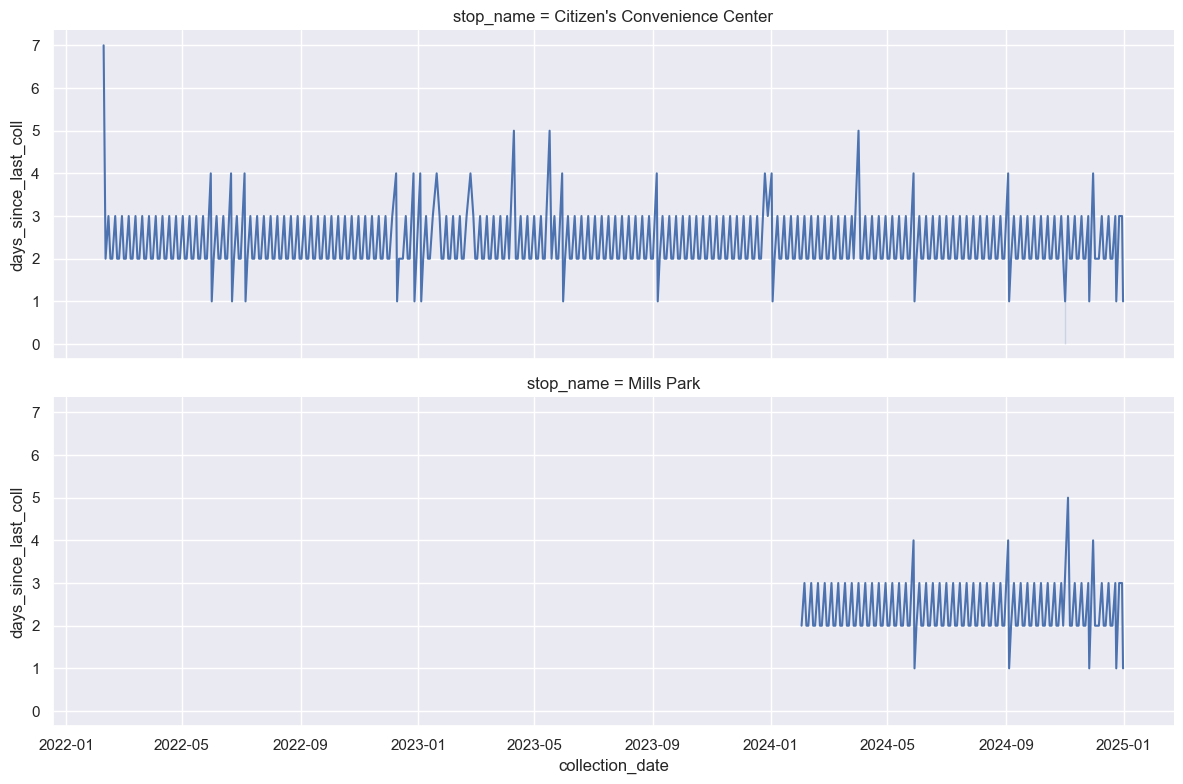

In [70]:
# visualize days since collection over time
g = sns.FacetGrid(coll_wk, col="stop_name", col_wrap=1, height=4, aspect=3)
g.map_dataframe(sns.lineplot, x="collection_date", y="days_since_last_coll")

In [71]:
coll_wk.groupby('stop_name')['days_since_last_coll'].describe()

,count,mean,std,min,25%,50%,75%,max
stop_name,,,,,,,,
Citizen's Convenience Center,449.0,2.367483,0.678702,0.0,2.0,2.0,3.0,7.0
Mills Park,143.0,2.342657,0.617867,1.0,2.0,2.0,3.0,5.0


Seems like collections occur (usually) every 2-3 days, but it can vary. Perhaps it varies based on holidays?

<Axes: xlabel='food_waste_collected', ylabel='estimated_earned_compost_created'>

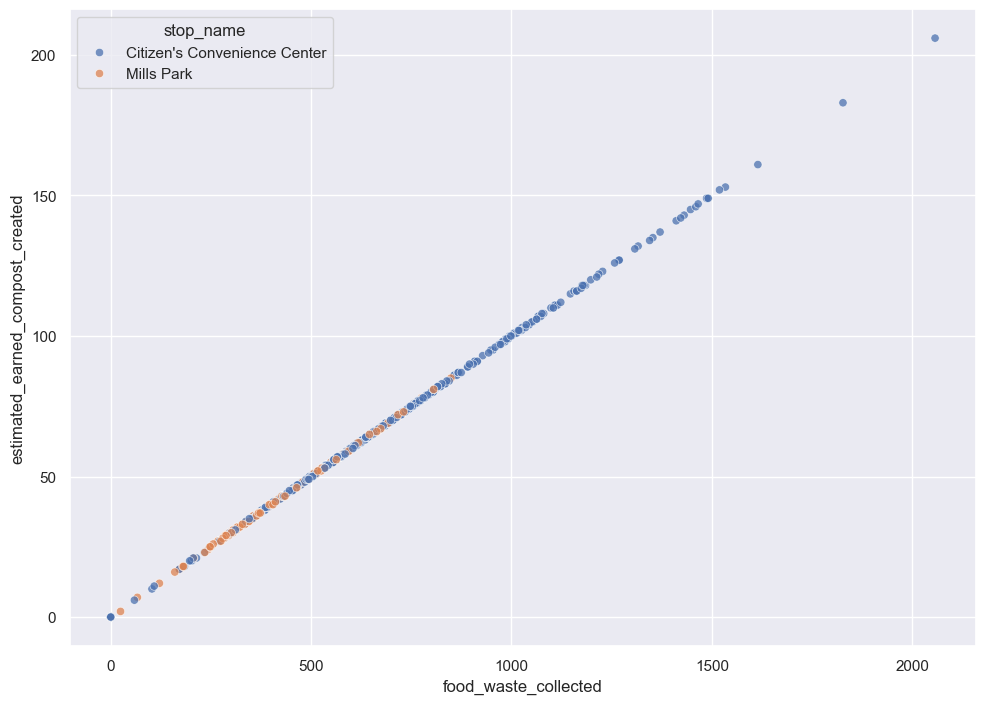

In [35]:
# I expect that compost generated has a monotically increasing relationship with waste collected, but let's double check that
sns.scatterplot(data=coll_wk, x="food_waste_collected", y="estimated_earned_compost_created", hue="stop_name", alpha=0.75)

The relationship between compost created and waste collected is as expected!

<Axes: xlabel='date', ylabel='estimated_drop_offs_containing_food_waste'>

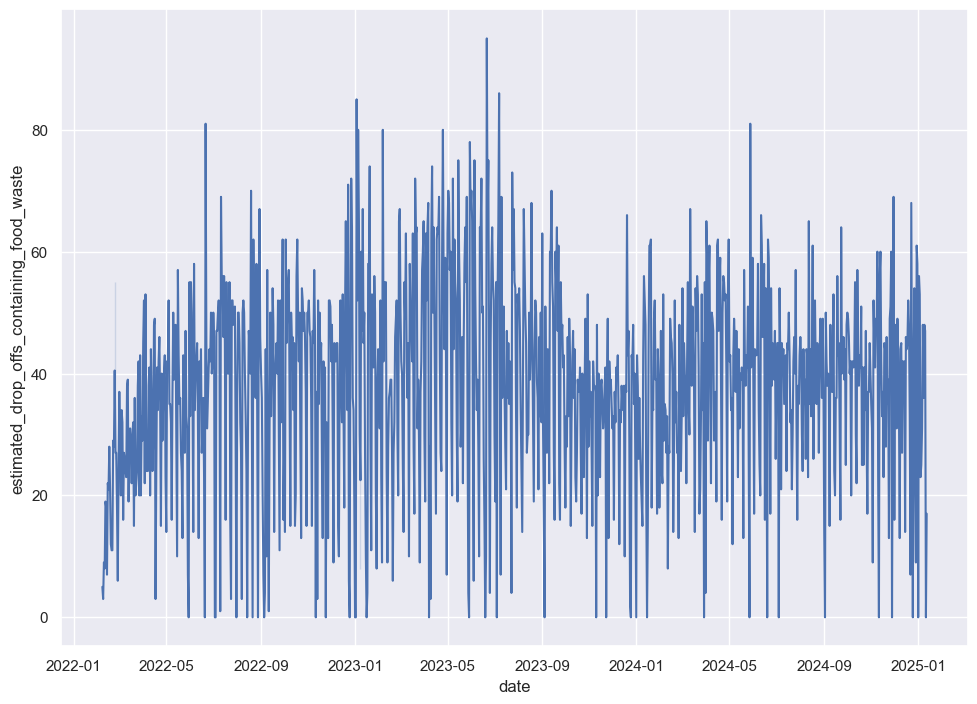

In [36]:
# visualize the estimated number of collections per date
sns.lineplot(data=part, x="date", y="estimated_drop_offs_containing_food_waste")

In [40]:
# combine estimated number of drop offs with waste collected
coll_wk2 = coll_wk.merge(part.assign(stop_name="Citizen's Convenience Center"), left_on=["stop_name", "collection_date"], right_on=["stop_name", "date"], how="outer")

In [47]:
# investigate the merge performance
coll_wk2['combined_date'] = coll_wk2['collection_date'].combine_first(coll_wk2['date'])
coll_wk2.sort_values('combined_date').iloc[40:60, :]

,stop_name,collection_date,food_waste_collected,estimated_earned_compost_created,date,estimated_drop_offs_containing_food_waste,combined_date
40,Citizen's Convenience Center,NaT,NaN,NaN,2022-03-17,22.0,2022-03-17
41,Citizen's Convenience Center,2022-03-18,303.8,30.0,2022-03-18,30.0,2022-03-18
42,Citizen's Convenience Center,NaT,NaN,NaN,2022-03-19,32.0,2022-03-19
43,Citizen's Convenience Center,NaT,NaN,NaN,2022-03-20,15.0,2022-03-20
44,Citizen's Convenience Center,2022-03-21,601.2,60.0,2022-03-21,36.0,2022-03-21
45,Citizen's Convenience Center,NaT,NaN,NaN,2022-03-22,20.0,2022-03-22
46,Citizen's Convenience Center,2022-03-23,481.8,48.0,2022-03-23,22.0,2022-03-23
47,Citizen's Convenience Center,NaT,NaN,NaN,2022-03-24,24.0,2022-03-24
48,Citizen's Convenience Center,2022-03-25,359.8,36.0,2022-03-25,38.0,2022-03-25
49,Citizen's Convenience Center,NaT,NaN,NaN,2022-03-26,42.0,2022-03-26


Since drop-offs happen more frequently than collections, to get the total number of drop-offs for a given collection date, would need to aggregate based on the collection date.

In [51]:
# I think filling "collection_date" backwards (after sorting by combined date) will achieve this aggregation
coll_wk2['collection_date'] = coll_wk2.collection_date.bfill()
coll_wk2.sort_values('combined_date').iloc[40:60, :]

,stop_name,collection_date,food_waste_collected,estimated_earned_compost_created,date,estimated_drop_offs_containing_food_waste,combined_date
40,Citizen's Convenience Center,2022-03-18,NaN,NaN,2022-03-17,22.0,2022-03-17
41,Citizen's Convenience Center,2022-03-18,303.8,30.0,2022-03-18,30.0,2022-03-18
42,Citizen's Convenience Center,2022-03-21,NaN,NaN,2022-03-19,32.0,2022-03-19
43,Citizen's Convenience Center,2022-03-21,NaN,NaN,2022-03-20,15.0,2022-03-20
44,Citizen's Convenience Center,2022-03-21,601.2,60.0,2022-03-21,36.0,2022-03-21
45,Citizen's Convenience Center,2022-03-23,NaN,NaN,2022-03-22,20.0,2022-03-22
46,Citizen's Convenience Center,2022-03-23,481.8,48.0,2022-03-23,22.0,2022-03-23
47,Citizen's Convenience Center,2022-03-25,NaN,NaN,2022-03-24,24.0,2022-03-24
48,Citizen's Convenience Center,2022-03-25,359.8,36.0,2022-03-25,38.0,2022-03-25
49,Citizen's Convenience Center,2022-03-28,NaN,NaN,2022-03-26,42.0,2022-03-26


In [55]:
# aggregating drop offs
agg_do = coll_wk2.groupby(['stop_name', 'collection_date'], as_index=False).agg({'estimated_drop_offs_containing_food_waste':'sum'})

# combine with original data
coll_wk3 = coll_wk.merge(agg_do, on=['stop_name', 'collection_date'], how="left")

In [56]:
# now calculate estimated food waste collected per drop off
coll_wk3 = coll_wk3.assign(food_waste_per_drop_off=lambda x: x['food_waste_collected']/x['estimated_drop_offs_containing_food_waste'],
                           compost_per_drop_off=lambda x: x['estimated_earned_compost_created']/x['estimated_drop_offs_containing_food_waste'])

<Axes: xlabel='collection_date', ylabel='food_waste_per_drop_off'>

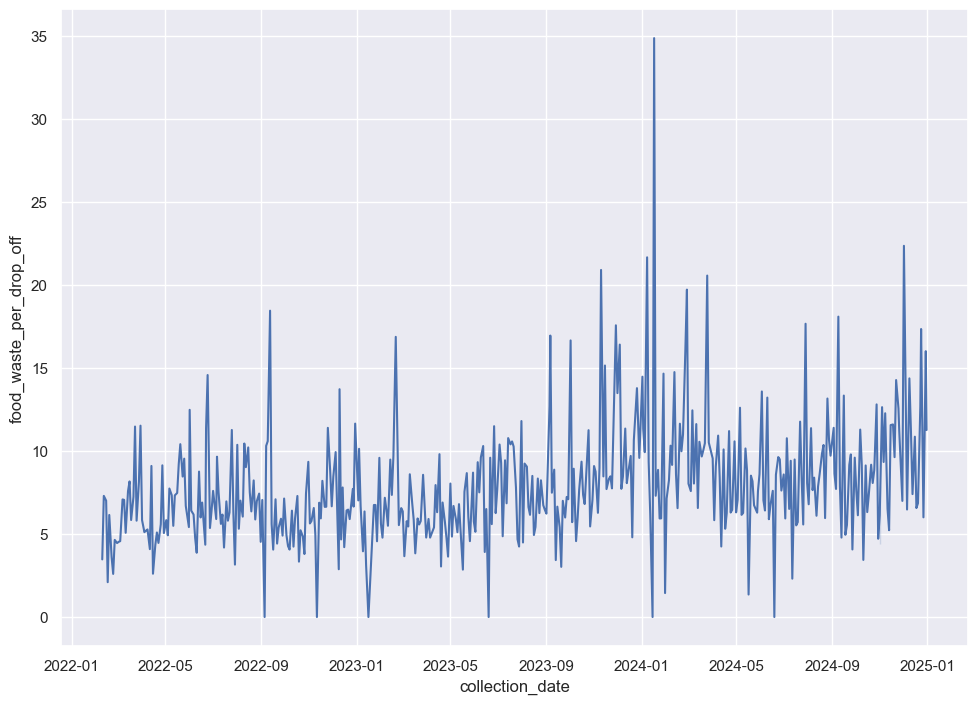

In [57]:
# visualize estimated food waste and compost created (in pounds) per drop off
sns.lineplot(data=coll_wk3, x="collection_date", y="food_waste_per_drop_off")

<Axes: xlabel='collection_date', ylabel='compost_per_drop_off'>

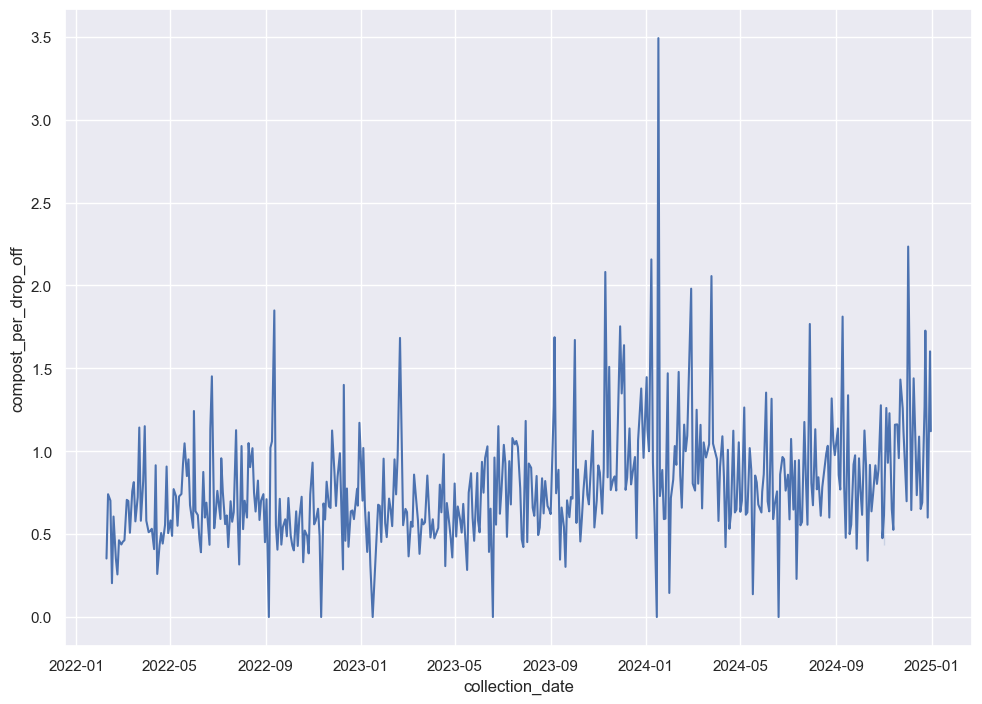

In [58]:
# visualize estimated food waste and compost created (in pounds) per drop off
sns.lineplot(data=coll_wk3, x="collection_date", y="compost_per_drop_off")

In [64]:
coll_wk3[(coll_wk3['stop_name'] == "Citizen's Convenience Center")].describe()

,collection_date,food_waste_collected,estimated_earned_compost_created,estimated_drop_offs_containing_food_waste,food_waste_per_drop_off,compost_per_drop_off
count,450,450.000000,450.000000,450.000000,449.000000,449.000000
mean,2023-07-22 14:30:24,687.700222,68.717778,90.573333,7.900312,0.789387
min,2022-02-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022-10-26 12:00:00,511.800000,51.000000,76.000000,5.780000,0.574713
50%,2023-07-25 00:00:00,644.100000,64.000000,90.000000,7.182143,0.717949
75%,2024-04-16 12:00:00,815.700000,82.000000,105.000000,9.537705,0.952381
max,2024-12-31 00:00:00,2057.000000,206.000000,441.000000,34.864407,3.491525
std,NaN,298.422215,29.861490,30.978550,3.624219,0.362525


## Next Steps

* Do other nearby towns or cities have data like this? Might be interesting to compare collection information 
* Look into Wake "WASTE CHARACTERIZATION STUDY" - is there publicy available data from this study?
* See if other waste collection data is available to analyze food waste alongside that data; would it be possible to see decreases in general waste with the rise of food waste collection?